In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# %load_ext autoreload
# %autoreload 2

# Load data
file_path = r'C:\Users\pablo\vscode101\sql-database\AB_NYC_2019.csv'

# df1 = pd.read_csv(file_path, sep=",")
df1 = pd.read_csv(file_path)

# Quick look at columns and missingness
# display(df.info())
# Display the first few rows
# df.info()
# df.dtypes
# df.nunique()
# df.describe()
# display(df.isna().sum())
# display((df.isna().sum()/df.shape[0])*100)
# df.head()

df1.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
# Drop unnecessary columns
columns_to_drop = ['id', 'host_id', 'host_name', 'latitude', 'longitude', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count']
def drop_irrelevant_columns(df1: pd.DataFrame, columns) -> pd.DataFrame:
    return df1.drop(columns=columns, errors='ignore')

df1 = drop_irrelevant_columns(df1, columns_to_drop)

In [4]:
df1.loc[df1.index, 'name'] = df1['name'].apply(
    lambda x: re.sub(r'[^A-Za-z0-9 ]+', '', x) if isinstance(x, str) else x
)

In [5]:
df1.head(5)

,name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,availability_365
0,Clean quiet apt home by the park,Brooklyn,Kensington,Private room,149,1,365
1,Skylit Midtown Castle,Manhattan,Midtown,Entire home/apt,225,1,355
2,THE VILLAGE OF HARLEMNEW YORK,Manhattan,Harlem,Private room,150,3,365
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,Entire home/apt,89,1,194
4,Entire Apt Spacious StudioLoft by central park,Manhattan,East Harlem,Entire home/apt,80,10,0


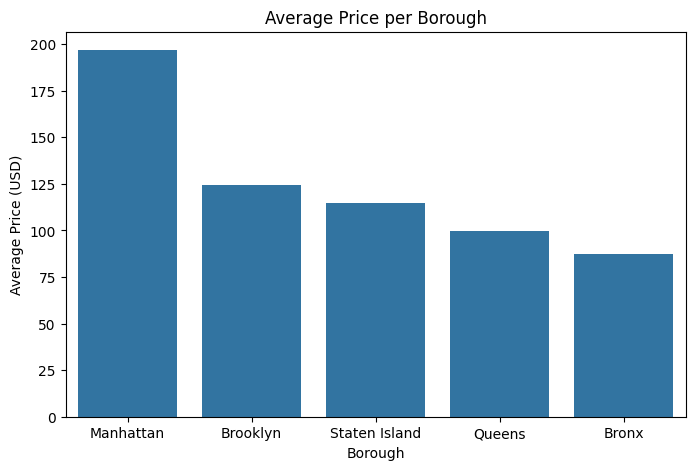

In [7]:
# Calculate average price per borough
avg_price_borough = df1.groupby('neighbourhood_group')['price'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=avg_price_borough, x='neighbourhood_group', y='price')
plt.title('Average Price per Borough')
plt.ylabel('Average Price (USD)')
plt.xlabel('Borough')
plt.show()

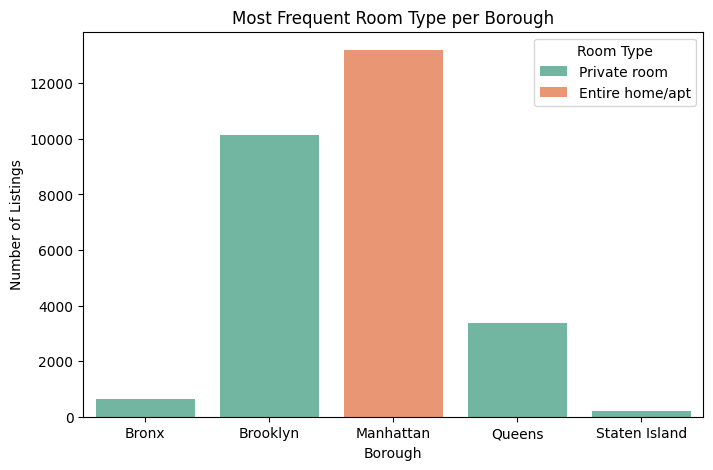

In [8]:
# Find most frequent room type per borough
room_type_counts = df1.groupby(['neighbourhood_group', 'room_type']).size().reset_index(name='count')
most_freq_room = room_type_counts.sort_values(['neighbourhood_group','count'], ascending=[True, False]) \
    .groupby('neighbourhood_group').first().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=most_freq_room, x='neighbourhood_group', y='count', hue='room_type', dodge=False, palette='Set2')
plt.title('Most Frequent Room Type per Borough')
plt.ylabel('Number of Listings')
plt.xlabel('Borough')
plt.legend(title='Room Type')
plt.show()

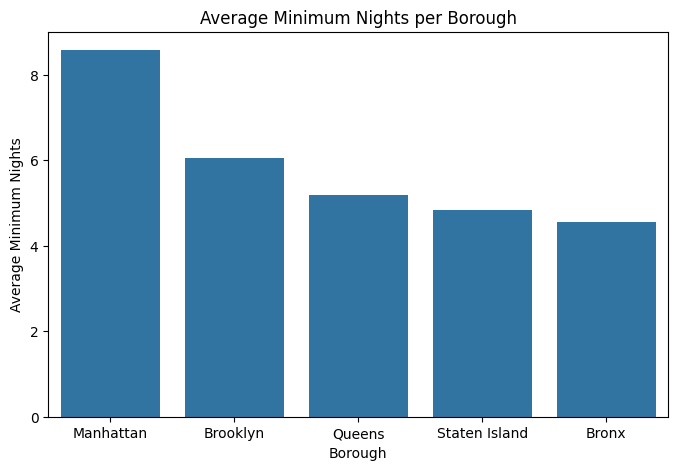

In [10]:
# Calculate average minimum nights per borough
avg_min_nights = df1.groupby('neighbourhood_group')['minimum_nights'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=avg_min_nights, x='neighbourhood_group', y='minimum_nights')
plt.title('Average Minimum Nights per Borough')
plt.ylabel('Average Minimum Nights')
plt.xlabel('Borough')
plt.show()

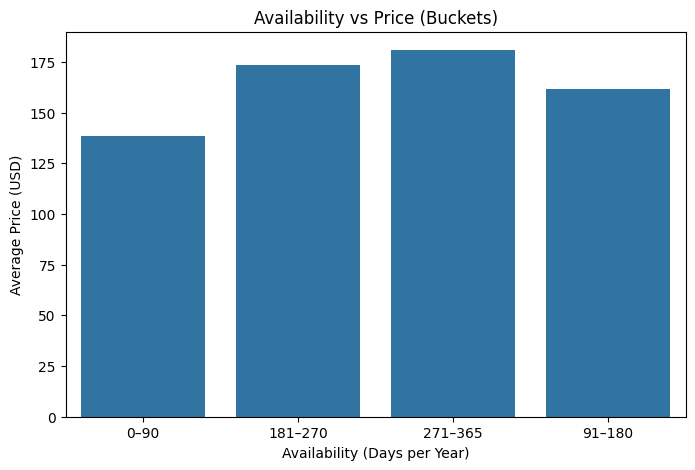

In [12]:
# Create availability buckets
def availability_bucket(x):
    if 0 <= x <= 90:
        return '0–90'
    elif 91 <= x <= 180:
        return '91–180'
    elif 181 <= x <= 270:
        return '181–270'
    else:
        return '271–365'

df1['availability_bucket'] = df1['availability_365'].apply(availability_bucket)
avail_price = df1.groupby('availability_bucket')['price'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=avail_price, x='availability_bucket', y='price')
plt.title('Availability vs Price (Buckets)')
plt.xlabel('Availability (Days per Year)')
plt.ylabel('Average Price (USD)')
plt.show()

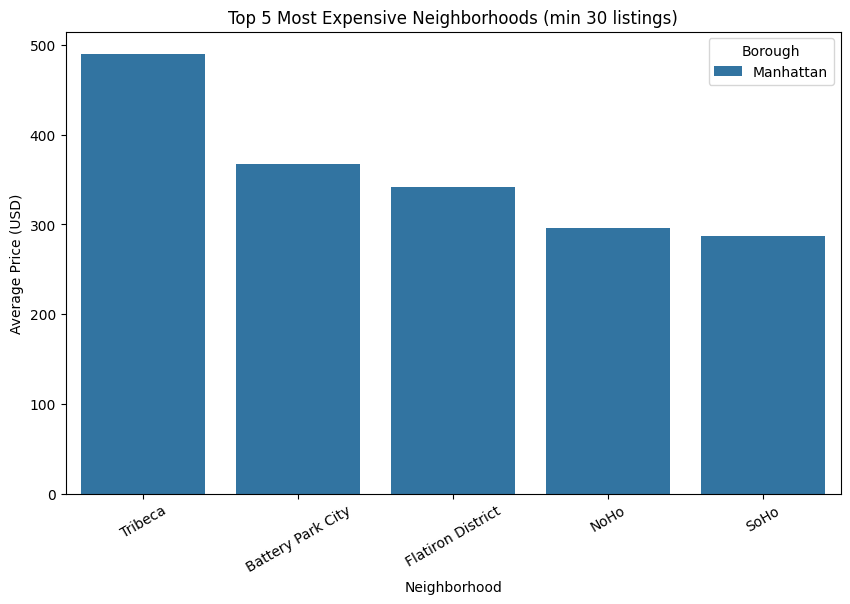

In [13]:
# Find top 5 most expensive neighborhoods with at least 30 listings
neigh_prices = df1.groupby(['neighbourhood_group','neighbourhood']).agg(
    avg_price=('price', 'mean'),
    listings=('price', 'size')
).reset_index()

top_neigh = neigh_prices[neigh_prices['listings'] >= 30].sort_values('avg_price', ascending=False).head(5)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top_neigh, 
    x='neighbourhood', 
    y='avg_price', 
    hue='neighbourhood_group',
    dodge=False,
    palette='tab10'
)
plt.title('Top 5 Most Expensive Neighborhoods (min 30 listings)')
plt.ylabel('Average Price (USD)')
plt.xlabel('Neighborhood')
plt.xticks(rotation=30)
plt.legend(title='Borough')
plt.show()